(min_uptime_downtime)=
# Minimum up- and downtime

## Introduction
This documentation demonstrates how to apply the constraints for minimum up- and downtime under the **MIN_UPTIME_DOWNTIME_FUNCTIONALITY** license for generators, pumps and plants. 

The model setup for this example is available in the following format:

- pyshop
    - [](min_uptime_downtime_model_generator.py)
    - [](min_uptime_downtime_model_plant.py)

Note that currently this feature is only available with constant time resolution for the whole optimization period. The time resolution should be given in hours or minutes. The minimum up- and downtime attributes are given as constants in minutes. 

## Minimum up- and downtime on generators

Minimum up- and downtime constraints can be set for [generators](generator) using the attributes [min_uptime](generator:min_uptime) and [min_downtime](generator:min_downtime). The constraints can be turned on or off for parts of the optimization period using the flag variables [min_uptime_flag](generator:min_uptime_flag) and [min_downtime_flag](generator:min_downtime_flag). 

If the generator attribute [historical_production](generator:historical_production) is set, SHOP will automatically find the state of the generator at the beginning of the optimization period as well as for how long the generator has been in that state. This will impose constraints on the generator state from the very first time step of the optimization period. 

Equivalent variables are also available for [pumps](pump): [min_uptime](pump:min_uptime), [min_downtime](pump:min_downtime), [min_uptime_flag](pump:min_uptime_flag) and [min_downtime_flag](pump:min_downtime_flag). Historical pump consumption data can be provided through the [historical_consumption](pump:historical_consumption) attribute.

### Imports

In [1]:
#Necessary imports used in all examples
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px

from pyshop import ShopSession

#Functions used in this example for building a basic SHOP model and running it
from min_uptime_downtime_model_generator import build_model, run_model
from min_uptime_downtime_model_plant import build_model_plant, run_model_plant

### Create a SHOP session and import basic model 
Our example model consists of two reservoirs and two plants with one generator each.

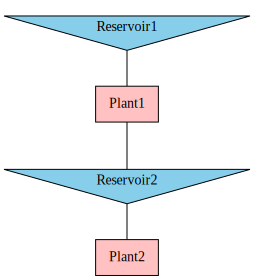

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a basic SHOP model
build_model(shop)
#Display topology to the screen
display(shop.model.build_connection_tree())

### Add market

We add a market with varying spot price so that the generators will turn on and off several times when no minimum up- or downtime constraints are present.

In [3]:
# Plot market price and water value of reservoirs
spot_price=shop.model.market.Day_ahead.sale_price.get()

fig = go.Figure()
colorscale = px.colors.sequential.RdBu_r
color = 1
fig.add_trace(go.Scatter(x=spot_price.index, marker_color = colorscale[color], y=spot_price.values, name="Market price"))

for rsv in shop.model.reservoir:
    color+=1
    end_water_value=rsv.energy_value_input.get()
    water_value=pd.Series([end_water_value]*len(spot_price),index=spot_price.index)
    curve_name="Water value of "+rsv.get_name()
    fig.add_trace(go.Scatter(x=water_value.index, y=water_value.values, marker_color = colorscale[color], name=curve_name, line=dict(dash="dot")))
    
fig.update_layout(title="<b>Market price and water value of reservoirs</b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Price</b> (€/MWh)")

fig.show()

### Run SHOP
We run SHOP without any minimum up-or downtime constraints for later comparison.

In [4]:
run_model(shop)

### Generator production

The plot below shows the generator production without any constraints on the minimum up- or downtime of the generators. Due to the varying market price, the generators are turned on and off frequently.

In [5]:
### Generator production with no uptime- or downtime constraints
fig = go.Figure()
fig.update_layout(title = f"Generator production", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Production</b> (MW)")
colorscale = px.colors.sequential.Magenta
for i, gen in enumerate(shop.model.generator):
    data=gen.production.get()
    fig.add_trace(go.Bar(x=data.index, y=data.values, name=gen.get_name(), marker_color=colorscale[i]))
fig.show()

### Add minimum uptime and downtime constraints

We set the minimum up- and down-times for the generators, which must be given in minutes. The minimum up- and downtimes should be divisible by the time resolution, otherwise they will be rounded up. 

For the second generator we set the up- and downtime flags so that the constraints are only applied after 12 hours.

In [6]:
shop2=ShopSession()
build_model(shop2)
starttime=shop2.get_time_resolution()["starttime"]

shop2.model.generator.Plant1_G1.min_downtime.set(120)
shop2.model.generator.Plant1_G1.min_uptime.set(180)

shop2.model.generator.Plant2_G1.min_uptime.set(240)
shop2.model.generator.Plant2_G1.min_downtime.set(240)
shop2.model.generator.Plant2_G1.min_downtime_flag.set(pd.Series([0,1],index=[starttime, starttime + pd.Timedelta(hours=12)]))
shop2.model.generator.Plant2_G1.min_uptime_flag.set(pd.Series([0,1],index=[starttime, starttime + pd.Timedelta(hours=12)]))


### Add historical production data

Historical production data can be given as input for each generator, so that SHOP can automatically find the state of the generator right before the start of the optimization period, and for how long the generator has been in that state. In this example, our generators have previously been turned on for two hours. Note that if the time spent in the initial state before the start of the optimization period is not divisible by the time resolution, it will be rounded up.

In [7]:
historical_production= pd.Series([0,30], index=[starttime - pd.Timedelta(hours=6), starttime - pd.Timedelta(hours=2)])
for gen in shop2.model.generator:
    gen.historical_production.set(historical_production)

### Run SHOP
We run SHOP with our applied constraints

In [8]:
run_model(shop2)

### Plots and results

The plot below shows the generator production with our applied constraints on the up- and downtimes. Notice how the historical production data is taken into account, forcing the first generator to remain turned on for the first time step, even though the market price is very low. The second generator, however, is turned off here as no constraints are applied to it for the first twelve hours.

In [9]:
fig = go.Figure()
fig.update_layout(title = f"Generator production", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Production</b> (MW)")
colorscale = px.colors.sequential.Magenta
for i, gen in enumerate(shop2.model.generator):
    data=gen.production.get()
    fig.add_trace(go.Bar(x=data.index, y=data.values, name=gen.get_name(), marker_color=colorscale[i]))
fig.show()

## Minimum up- and downtime on plants
Minimum up- and downtime constraints can also be set on [plant](plant) level with the plant attributes [min_uptime](plant:min_uptime) and [min_downtime](plant:min_downtime). The constraints can be turned on or off for parts of the optimization period using the plant flag variables [min_uptime_flag](plant:min_uptime_flag) and [min_downtime_flag](plant:min_downtime_flag). 

The plant is on if one or more of its pumps and/or generators is on, and the plant is off if all of its pumps and generators are off. Historical data for determining the plant's initial state can be provided through the [historical_production](plant:historical_production) and [historical_consumption](plant:historical_consumption) attributes on plant level. If these are not provided, the corresponding attributes for the plant's generators ([historical_production](generator:historical_production)) and pumps ([historical_consumption](pump:historical_consumption)) will be used. If no historical data is provided, no constraints are applied to the first time step of the optimization.

We will use a similar model as we did for the generator example, but now with two generators on Plant1 and a pump added to Plant2. Plant1 has minimum up- and downtimes of 3 hours, while Plant2 has minimum up- and downtimes of 2 hours. We apply the minimum up- and downtime constraints for both plants and run the model.

In [10]:
shop3=ShopSession()
build_model_plant(shop3)

shop3.model.plant.Plant1.min_downtime.set(3*60)
shop3.model.plant.Plant1.min_uptime.set(3*60)

shop3.model.plant.Plant2.min_uptime.set(2*60)
shop3.model.plant.Plant2.min_downtime.set(2*60)

run_model_plant(shop3)


As can be seen, the plants are restricted by their minimum up- and downtimes. The generators and pumps do not have any individual constraints, but together they fulfill the plant restrictions.

In [11]:
color_arr=[px.colors.sequential.Blues, px.colors.sequential.Magenta]
mi = 5

fig = go.Figure()
fig.update_layout(title = f"Sum of plant production and consumption", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Production/Consumption</b> (MW)")
for i, plant in enumerate(shop3.model.plant):
    data=plant.production.get() + plant.consumption.get()
    fig.add_trace(go.Bar(x=data.index, y=data.values, name=plant.get_name(), marker_color=color_arr[i][mi-2*i]))
fig.show()

fig = go.Figure()
plant = shop3.model.plant.Plant1
fig.update_layout(title = f"Generator production and pump consumption for {plant.get_name()}", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Production/Consumption</b> (MW)")
pump = shop3.model.pump.Plant1_P1
cons = pump.consumption.get()
fig.add_trace(go.Bar(x=cons.index, y=cons.values, name="Consumption "+pump.get_name(), marker_color=color_arr[0][mi-1]))
gen = shop3.model.generator.Plant1_G1
prod = gen.production.get()
fig.add_trace(go.Bar(x=prod.index, y=prod.values, name="Production "+gen.get_name(), marker_color=color_arr[0][mi-2]))
fig.show()

fig = go.Figure()
plant = shop3.model.plant.Plant2
fig.update_layout(title = f"Generator production for {plant.get_name()}", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Production/Consumption</b> (MW)")
for i, gen in enumerate(shop3.model.plant.Plant2.generators):
    prod=gen.production.get()
    fig.add_trace(go.Bar(x=prod.index, y=prod.values, name="Production "+gen.get_name(), marker_color=color_arr[1][mi-3-2*i]))
fig.show()
